In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation, Dropout, Input
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from keras.callbacks import TensorBoard
from keras.models import Model
from keras.utils import np_utils
import itertools
import matplotlib.pyplot as plt
import livelossplot
%matplotlib inline
import tensorflow as tf
plot_losses = livelossplot.PlotLossesKeras()

Using TensorFlow backend.


In [2]:
PATH = 'C:/Users/SDGT/Downloads/food-5K/'

train_path = '%straining/' %PATH
valid_path = '%svalidation/' %PATH
test_path = '%sevaluation/' %PATH

classes = ('food', 'non-food')

print (train_path)

C:/Users/SDGT/Downloads/food-5K/training/


In [13]:
batch_size=16
epochs = 20
nb_train_samples = 3001
nb_validation_samples = 1000

train_batches = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2, horizontal_flip=True).flow_from_directory(train_path, 
                                                                                                             target_size=(224,224),
                                                                                                             batch_size=32, 
                                                                                                             class_mode='binary')
valid_batches = ImageDataGenerator(rescale = 1./255 ).flow_from_directory(valid_path, target_size=(224,224), 
        batch_size=batch_size, class_mode='binary')
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), 
        batch_size=batch_size, class_mode='binary')

print(type(train_batches[0]))

x_train, y_train = train_batches[0]
x_test, y_test = valid_batches[0]

print('x_train.shape: ' + str(x_train.shape))
print('y_train.shape: ' + str(y_train.shape))
print('y_train.shape: ' + str(y_train.reshape(y_train.shape + (1,)).shape))

print('x_test.shape: ' + str(x_test.shape))
print('y_test.shape: ' + str(y_test.shape))
print('y_test.shape: ' + str(y_test.reshape(y_test.shape + (1,)).shape))

X_train_flatten = x_train.reshape(x_train.shape[0], -1).T
X_test_flatten = x_test.reshape(x_test.shape[0], -1).T

y_train_flatten = y_train.T
y_test_flatten = y_test.T

print('X_train_flatten.shape: ' + str(X_train_flatten.T.shape))
print('y_train_flatten.shape: ' + str(y_train_flatten.shape))
#print('y_train_flatten.shape: ' + str(np.squeeze(y_train_flatten, axis=(2,)).shape))

print('X_test_flatten.shape: ' + str(X_test_flatten.T.shape))
print('y_test_flatten.shape: ' + str(y_test_flatten.shape))
#print('y_test_flatten.shape: ' + str(np.squeeze(y_test_flatten, axis=(2,)).shape))

train_set_x = X_train_flatten/255.
test_set_x = X_test_flatten/255.

print('len(train_set_x): ' + str(train_set_x.shape))
print('len(test_set_x): ' + str(test_set_x.shape))

print(y_train.shape)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
<class 'tuple'>
x_train.shape: (32, 224, 224, 3)
y_train.shape: (32,)
y_train.shape: (32, 1)
x_test.shape: (16, 224, 224, 3)
y_test.shape: (16,)
y_test.shape: (16, 1)
X_train_flatten.shape: (32, 150528)
y_train_flatten.shape: (32,)
X_test_flatten.shape: (16, 150528)
y_test_flatten.shape: (16,)
len(train_set_x): (150528, 32)
len(test_set_x): (150528, 16)
(32,)


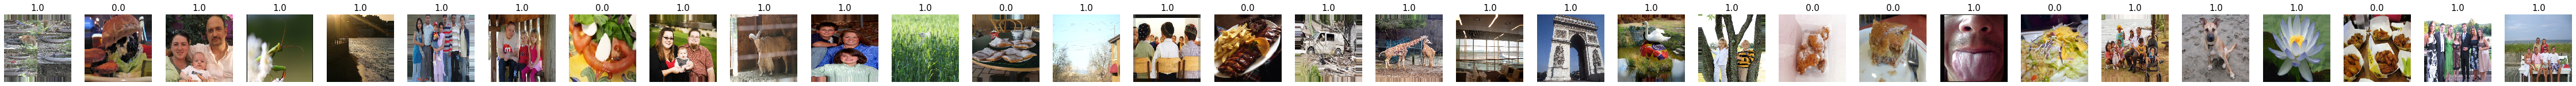

In [14]:
def plots(ims, figsize=(80,60), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        #print(ims[0])
        #ims = np.array(ims).astype(np.uint8)
        #print(ims)
        
        if (ims.shape[-1] != 3):
            ims = ims.transpose((1,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=15)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

In [15]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 224 X 224 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)       

In [17]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_batches, steps_per_epoch=32, #steps_per_epoch=nb_train_samples, 
                              validation_steps = 16,
                    validation_data=valid_batches, epochs=epochs, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 16 steps
Epoch 1/20
32/32 [==============================] - 99s 3s/step - loss: 0.6759 - accuracy: 0.6123 - val_loss: 1.0816 - val_accuracy: 0.5820
Epoch 2/20
32/32 [==============================] - 98s 3s/step - loss: 0.5328 - accuracy: 0.7607 - val_loss: 0.4995 - val_accuracy: 0.8008
Epoch 3/20
32/32 [==============================] - 74s 2s/step - loss: 0.4722 - accuracy: 0.7881 - val_loss: 0.5047 - val_accuracy: 0.7930
Epoch 4/20
32/32 [==============================] - 71s 2s/step - loss: 0.4771 - accuracy: 0.7891 - val_loss: 0.4539 - val_accuracy: 0.7773
Epoch 5/20
32/32 [==============================] - 59s 2s/step - loss: 0.4298 - accuracy: 0.8140 - val_loss: 0.4067 - val_accuracy: 0.8047
Epoch 6/20
32/32 [==============================] - 54s 2s/step - loss: 0.4564 - accuracy: 0.7891 - val_loss: 0.4374 - val_accuracy: 0.8281
Epoch 7/20
32/32 [==============================] - 50s 2s/step - lo

In [19]:
x_test, y_test = test_batches[0]
evaluation = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

16/16 [==============================] - 2s 148ms/sample - loss: 0.1136 - accuracy: 0.9375
Summary: Loss over the test dataset: 0.11, Accuracy: 0.94


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


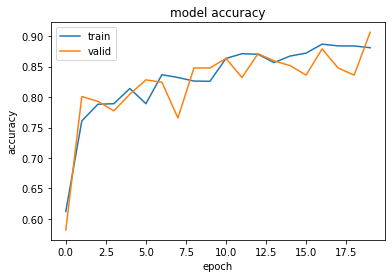

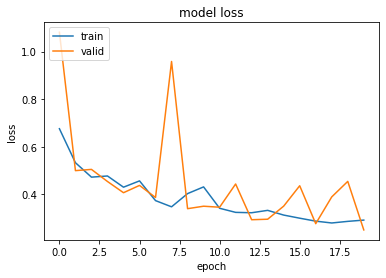

In [20]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [44]:
from keras.preprocessing import image

test_image=image.load_img("C:/Users/SDGT/Downloads/food7.jpg",target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
#training_set.class_indices
result

array([[0.]], dtype=float32)